In [225]:

import os
from osgeo import gdal,ogr,osr
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import rasterio
from rasterio.plot import show
from random import randint
from statistics import pstdev 

path = r'C:\Users\ximis\workspace\pnt\imagens_landsat\landsat8\ndvi_analises2'

def GetExtent(gt,cols,rows):
    #Return list of corner coordinates from a geotransform
    ext = []
    xarr=[0,cols]
    yarr=[0,rows]
    
    
    for px in xarr:
        for py in yarr:
            x=gt[0]+(px*gt[1])+(py*gt[2])
            y=gt[3]+(px*gt[4])+(py*gt[5])
            ext.append([x,y])
            
            #print (x,y)
        yarr.reverse()
    return ext
    

rasters = []


for el in os.listdir(path): 
    if el.endswith('tif') or el.endswith('TIF'):
        
        data = (el.split('_')[3])
        data = data[0:4]+'-'+data[4:6]+'-'+data[6:8]
        data = datetime.strptime(data,'%Y-%m-%d')
        x = {'file':path+'/'+el , 'data': data}
        rasters.append(x)

datas = []
for el in rasters:
    datas.append(el['data'])

datas.sort()


rasters_ordem=[]
for el in datas:
    for r in rasters:
        if el == r['data']:
            rasters_ordem.append(r['file'])

rasters_dict = []

for c in range(len(rasters_ordem)):
    x= {'data':datas[c] , 'file': rasters_ordem[c]}
    rasters_dict.append(x)
            

#gera Array com o primeiro raster
raster1 = gdal.Open(rasters_ordem[0])
gt_1 = raster1.GetGeoTransform()
rows = raster1.RasterYSize
cols = raster1.RasterXSize
ext_1 = GetExtent(gt_1,cols,rows)
array1 = np.array(raster1.GetRasterBand(1).ReadAsArray())

#Cria Matriz Multidimensional com todos os Rasters


#def getMonthdatas(rasters_dict,mes):
    



def Stack(list_rasters,array1):
    
    n = len(list_rasters)

    stack = np.zeros((n,array1.shape[0],array1.shape[1]),np.float32)

    c=0
    for el in list_rasters:

        raster=''
        raster = gdal.Open(el)
        gt = raster.GetGeoTransform()
        cols = raster.RasterXSize
        rows = raster.RasterYSize
        ext = GetExtent(gt,cols,rows)
   
        if not ext == ext_1:
            print('FILE: '+el )
            print('EXT: '+str(gt[0])+str(gt[3]))
    
        array = np.array(raster.GetRasterBand(1).ReadAsArray())
        stack[c] = array
        c+=1
    
    return stack

def getAllValues(i,j,stack,rasters_dicts):
    bands_number = stack.shape[0]
    
    pixelsValues = [] 
    
    datas = []
    files = []
    
    for c in range(bands_number):
        if stack[c][j][i] >-1 and stack[c][j][i]<=1:
            pixelsValues.append(stack[c][j][i])
            datas.append(rasters_dict[c]['data'])
            files.append(rasters_dict[c]['file'])
    
    
    dif_ndvi = []
    dif_datas = []
    c = 0
    while c < len(pixelsValues)-1:        
        dif_ndvi.append(pixelsValues[c+1]-pixelsValues[c])
        date = (datas[c+1]-datas[c]).total_seconds()/86400       
        dif_datas.append(date)
        c+=1
    
    taxa_ndvi = []
    for c in range(len(dif_datas)):        
        taxa_ndvi.append(dif_ndvi[c]/dif_datas[c])
            
    
    points = {'values':pixelsValues, 'datas': datas, 'files' : files, 'taxa_ndvi' : taxa_ndvi, 'dif_ndvi': dif_ndvi }
    
    return points


def getMonthValues(points,mes):
    #print(points['dif_ndvi'])
    c = 0
    taxa_ndvi = []
    values = []
    datas = []
    dif_ndvi = []
    for d in points['datas'][1:]:
        if d.month == mes:
            datas.append(d)
            taxa_ndvi.append(points['taxa_ndvi'][c])
            dif_ndvi.append(points['dif_ndvi'][c])
  
            values.append(points['values'][c+1])
            
        c+=1
    
    month = {'datas' : datas, 'taxa_ndvi':taxa_ndvi,'values' : values, 'dif_ndvi' : dif_ndvi }
    return month



FinalArray = np.zeros((array1.shape[0],array1.shape[1]),np.float32)

stack = Stack(rasters_ordem,array1)
file2 = r'C:\Users\ximis\workspace\pnt\imagens_landsat\landsat8\ndvi_analises/LC08_L1TP_217076_20190616_20190620_01_T1_NDVI.tif'
raster2 = gdal.Open(file2)
array2 = stack[-1]


jan = []
fev = []
mar = []
abr = []
mai = []
jun = []
jul = []
ago = []
set = []
out = []
nov = []
dez = []

count= 0


def media(x):
    soma = sum(x)
    #print(x)
    if not len(x)==0:
        media = soma/len(x)
    elif len(x)==0:
        media = 0
    return media





GDAL_DATA_TYPE = gdal.GDT_Int32 
GEOTIFF_DRIVER_NAME = r'GTiff'
NO_DATA = 15
SPATIAL_REFERENCE_SYSTEM_WKID = 4326



def create_raster(output_path,
                  columns,
                  rows,
                  nband = 1,
                  gdal_data_type = GDAL_DATA_TYPE,
                  driver = GEOTIFF_DRIVER_NAME):
     #returns gdal data source raster object

    
    # create driver
    driver = gdal.GetDriverByName(driver)

    output_raster = driver.Create(output_path,
                                  int(columns),
                                  int(rows),
                                  nband,
                                  eType = gdal_data_type)    
#    print(type(output_raster))
    return output_raster


def FinalRaster (output,array,geot):        
    
    rows,cols = array.shape    
    
    raster = create_raster(output,cols,rows)
    spatial_reference = osr.SpatialReference()
    spatial_reference.ImportFromEPSG(32623)
    raster.SetProjection(spatial_reference.ExportToWkt())
    raster.SetGeoTransform(geot)
    output_band = raster.GetRasterBand(1)
    output_band.SetNoDataValue(int(2))
    output_band.WriteArray(array2)
    output_band.FlushCache()
    output_band.ComputeStatistics(True)



array2 = stack[103]
#print(rasters_dict)
#plt.imshow(array2)
#plt.show()

def main(k,r_dict,stack):
    
    FinalArray = np.zeros((array1.shape[0],array1.shape[1]),dtype = float)   
    
    rasters_dict = r_dict[0:104]
    stack = stack[0:106,:,:]
    for d in rasters_dict:
        if d['data'].month==10:
            print(d['file'])
            
    for i in range(cols):
        for j in range(rows):
            if array2[j][i]>-1 and array2[j][i]<1:
                points = getAllValues(i,j,stack,rasters_dict)
                marc = getMonthValues(points,10)
                dif = (array2[j][i]-marc['values'][-1])/15
                
                median = float(media(marc['taxa_ndvi']))
                if len(marc['taxa_ndvi'])>0:            
                    devPad = float(pstdev(marc['taxa_ndvi']))
                    sensor = (median-(devPad*k))
                    sensor2 = (median-(devPad*2*k))
                    sensor3 = (median-(devPad*3*k))
     
                    if sensor3 > dif and dif > sensor2: #marc['taxa_ndvi'][-1]:
                        FinalArray[j][i]=13 
                    
                    elif sensor2> dif and dif> sensor:
                        FinalArray[j][i]=12
                    
                    elif sensor> dif :
                        FinalArray[j][i]=11
                    
                    elif dif>sensor3:     #marc['taxa_ndvi'][-1]:
                        FinalArray[j][i]= 14
        
                                
                elif len(marc['taxa_ndvi']) == 0:
                    FinalArray[j][i] = 2
            elif array2[j][i]<-1:
                FinalArray[j][i] = 10
    
        
        
    #plt.imshow(FinalArray)
    #plt.show()
    return FinalArray

#main(0.5,rasters_dict,stack)

#print(len(stack))

In [226]:
def FinalRaster (output,array,geot):        
    
    rows,cols = array.shape    
    
    raster = create_raster(output,cols,rows)
    spatial_reference = osr.SpatialReference()
    spatial_reference.ImportFromEPSG(32623)
    raster.SetProjection(spatial_reference.ExportToWkt())
    raster.SetGeoTransform(geot)
    output_band = raster.GetRasterBand(1)
 #   output_band.SetNoDataValue(int(2))
    output_band.WriteArray(array)
    output_band.FlushCache()
    output_band.ComputeStatistics(True)

C:\Users\ximis\workspace\pnt\imagens_landsat\landsat8\ndvi_analises2/LC08_L1GT_217076_20131005_20170429_01_T2_NDVI.tif
C:\Users\ximis\workspace\pnt\imagens_landsat\landsat8\ndvi_analises2/LC08_L1TP_217076_20131021_20180528_01_T1_NDVI.tif
C:\Users\ximis\workspace\pnt\imagens_landsat\landsat8\ndvi_analises2/LC08_L1TP_217076_20141008_20170418_01_T1_NDVI.tif
C:\Users\ximis\workspace\pnt\imagens_landsat\landsat8\ndvi_analises2/LC08_L1TP_217076_20141024_20170418_01_T1_NDVI.tif
C:\Users\ximis\workspace\pnt\imagens_landsat\landsat8\ndvi_analises2/LC08_L1GT_099168_20151001_20170403_01_T2_NDVI.tif
C:\Users\ximis\workspace\pnt\imagens_landsat\landsat8\ndvi_analises2/LC08_L1TP_217076_20151011_20170403_01_T1_NDVI.tif
C:\Users\ximis\workspace\pnt\imagens_landsat\landsat8\ndvi_analises2/LC08_L1TP_217076_20151027_20170402_01_T1_NDVI.tif
C:\Users\ximis\workspace\pnt\imagens_landsat\landsat8\ndvi_analises2/LC08_L1TP_217076_20161013_20170319_01_T1_NDVI.tif


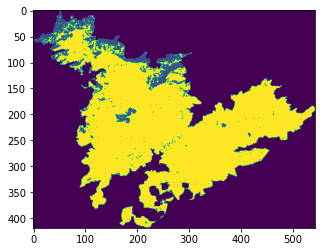

In [227]:
R1 = main(1,rasters_dict,stack)
output1 = r'C:\Users\ximis\workspace\pnt\imagens_landsat\relatoriofinal\K1_multiple.tif'
FinalRaster(output1,R1,gt_1)
plt.imshow(R1)
plt.show()


C:\Users\ximis\workspace\pnt\imagens_landsat\landsat8\ndvi_analises2/LC08_L1GT_217076_20131005_20170429_01_T2_NDVI.tif
C:\Users\ximis\workspace\pnt\imagens_landsat\landsat8\ndvi_analises2/LC08_L1TP_217076_20131021_20180528_01_T1_NDVI.tif
C:\Users\ximis\workspace\pnt\imagens_landsat\landsat8\ndvi_analises2/LC08_L1TP_217076_20141008_20170418_01_T1_NDVI.tif
C:\Users\ximis\workspace\pnt\imagens_landsat\landsat8\ndvi_analises2/LC08_L1TP_217076_20141024_20170418_01_T1_NDVI.tif
C:\Users\ximis\workspace\pnt\imagens_landsat\landsat8\ndvi_analises2/LC08_L1GT_099168_20151001_20170403_01_T2_NDVI.tif
C:\Users\ximis\workspace\pnt\imagens_landsat\landsat8\ndvi_analises2/LC08_L1TP_217076_20151011_20170403_01_T1_NDVI.tif
C:\Users\ximis\workspace\pnt\imagens_landsat\landsat8\ndvi_analises2/LC08_L1TP_217076_20151027_20170402_01_T1_NDVI.tif
C:\Users\ximis\workspace\pnt\imagens_landsat\landsat8\ndvi_analises2/LC08_L1TP_217076_20161013_20170319_01_T1_NDVI.tif


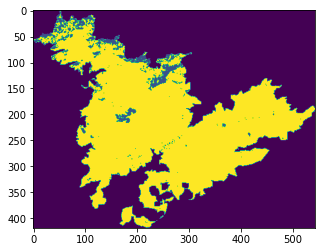

In [228]:
R2 = main(2,rasters_dict,stack)
output2 = r'C:\Users\ximis\workspace\pnt\imagens_landsat\relatoriofinal\K2_multiple.tif'
FinalRaster(output2,R2,gt_1)
plt.imshow(R2)
plt.show()

C:\Users\ximis\workspace\pnt\imagens_landsat\landsat8\ndvi_analises2/LC08_L1GT_217076_20131005_20170429_01_T2_NDVI.tif
C:\Users\ximis\workspace\pnt\imagens_landsat\landsat8\ndvi_analises2/LC08_L1TP_217076_20131021_20180528_01_T1_NDVI.tif
C:\Users\ximis\workspace\pnt\imagens_landsat\landsat8\ndvi_analises2/LC08_L1TP_217076_20141008_20170418_01_T1_NDVI.tif
C:\Users\ximis\workspace\pnt\imagens_landsat\landsat8\ndvi_analises2/LC08_L1TP_217076_20141024_20170418_01_T1_NDVI.tif
C:\Users\ximis\workspace\pnt\imagens_landsat\landsat8\ndvi_analises2/LC08_L1GT_099168_20151001_20170403_01_T2_NDVI.tif
C:\Users\ximis\workspace\pnt\imagens_landsat\landsat8\ndvi_analises2/LC08_L1TP_217076_20151011_20170403_01_T1_NDVI.tif
C:\Users\ximis\workspace\pnt\imagens_landsat\landsat8\ndvi_analises2/LC08_L1TP_217076_20151027_20170402_01_T1_NDVI.tif
C:\Users\ximis\workspace\pnt\imagens_landsat\landsat8\ndvi_analises2/LC08_L1TP_217076_20161013_20170319_01_T1_NDVI.tif


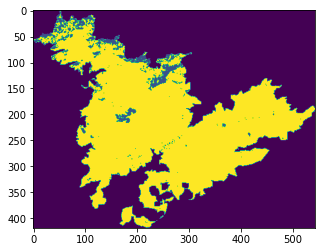

In [229]:
R3 = main(2,rasters_dict,stack)
output3 = r'C:\Users\ximis\workspace\pnt\imagens_landsat\relatoriofinal\K3_multiple.tif'
FinalRaster(output3,R3,gt_1)
plt.imshow(R3)
plt.show()